## CAM 구현 및 평가

In [4]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

### 데이터셋, 모델 불러오기

* stanford_dogs 데이터셋을 사용
* 120개의 견종으로 라벨링 되어 있음
* 총 20,580장 이미지 : train - 12,000장 / test - 8,580장

해당 내용대로 불러왔으며 test 중 80%를 검증데이터로 20%를 테스트데이터로 사용했습니다

* 프로젝트 요구사항에 따라, 모델은 ResNet50을 활용하여 학습을 진행

In [ ]:
(ds_train, ds_valid, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test[:80%]', 'test[80%:]'],
    shuffle_files=True,
    with_info=True,
)

In [11]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_valid))
print(tf.data.experimental.cardinality(ds_test))

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
    }),
})
tf.Tensor(12000, shape=(), dtype=int64)
tf.Tensor(6864, shape=(), dtype=int64)
tf.Tensor(1716, shape=(), dtype=int64)


In [12]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation="softmax")(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [13]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

### CAM 구현하기

In [14]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    ds = ds.batch(batch_size)
    if is_test == False:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [15]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_valid, is_test=True)

In [16]:
# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [17]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path = "./best_model_ResNet50_CAM_120dog.h5"

# ModelCheckpoint 콜백 설정
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,      # 저장할 파일 경로
    monitor='val_accuracy',        # 검증 정확도를 기준으로 저장
    save_best_only=True,           # 가장 좋은 모델만 저장
    save_weights_only=False,       # 모델 전체 저장 (True면 가중치만 저장)
    mode='max',                    # 높은 값이 좋음 (val_accuracy 최대값 저장)
    verbose=1                      # 저장될 때 로그 출력
)

history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test[:80%]'].num_examples/16),
    epochs=50,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50


2025-03-04 17:57:18.659944: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-03-04 17:57:18.886426: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-03-04 17:57:20.357001: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-03-04 17:57:20.389387: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x8972390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-04 17:57:20.389419: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-03-04 17:57:20.524067: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-03-04 17:57:20.572511: I ./tensorflow/compiler/jit/device_compiler.h:

750/750 [==============================] - 106s 124ms/step - loss: 2.2482 - accuracy: 0.4353 - val_loss: 3.1450 - val_accuracy: 0.2420
Epoch 2/50
750/750 [==============================] - 92s 123ms/step - loss: 0.7978 - accuracy: 0.7739 - val_loss: 1.2437 - val_accuracy: 0.6419
Epoch 3/50
750/750 [==============================] - 92s 123ms/step - loss: 0.2976 - accuracy: 0.9282 - val_loss: 1.0685 - val_accuracy: 0.6895
Epoch 4/50
750/750 [==============================] - 93s 124ms/step - loss: 0.0825 - accuracy: 0.9895 - val_loss: 0.9266 - val_accuracy: 0.7356
Epoch 5/50
750/750 [==============================] - 89s 119ms/step - loss: 0.0266 - accuracy: 0.9983 - val_loss: 0.9159 - val_accuracy: 0.7424
Epoch 6/50
750/750 [==============================] - 91s 121ms/step - loss: 0.0133 - accuracy: 0.9999 - val_loss: 0.9278 - val_accuracy: 0.7445
Epoch 7/50
750/750 [==============================] - 90s 120ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.9379 - val_accuracy: 0.

In [19]:
import json

# 학습 로그 저장
with open("./best_model_ResNet50_CAM_120dog.json", "w") as f:
    json.dump(history_cam_model.history, f)


4 에포크 이후에는 오버피팅으로 판단, 추가적인 학습은 필요없으며 CAM 및 Grad-CAM 결과를 확인하고 시간이 남으면 하이퍼파라미터 튜닝 진행

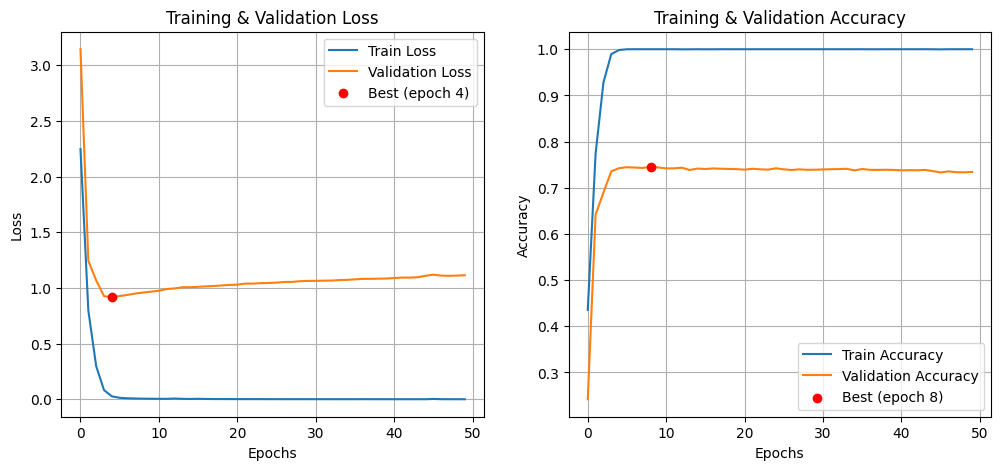

In [159]:
import json
import matplotlib.pyplot as plt
import numpy as np

# JSON 파일 로드
with open("./best_model_ResNet50_CAM_120dog.json", "r") as f:
    history = json.load(f)

# 학습 과정 데이터 가져오기
loss = history["loss"]
val_loss = history["val_loss"]
accuracy = history["accuracy"]
val_accuracy = history["val_accuracy"]

# 최적의 epoch 찾기 (Validation Loss가 최소인 지점)
best_epoch = val_loss.index(min(val_loss))

# 가장 높은 val_accuracy를 기록한 epoch 찾기
best_epoch_val_acc = np.argmax(val_accuracy)  # history에서 val_accuracy를 사용

# 해당 epoch에서의 Loss와 Accuracy 값 가져오기
best_val_loss = val_loss[best_epoch]
best_val_accuracy = val_accuracy[best_epoch_val_acc]

# 그래프 설정
plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.scatter(best_epoch, best_val_loss, color="red", label=f"Best (epoch {best_epoch})", zorder=3)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(accuracy, label="Train Accuracy")
plt.plot(val_accuracy, label="Validation Accuracy")
plt.scatter(best_epoch_val_acc, best_val_accuracy, color="red", label=f"Best (epoch {best_epoch_val_acc})", zorder=3)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid()

# 그래프 표시
plt.show()


In [22]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    # bbox = sample_data[0]['objects']['bbox']
    # image = sample_data[0]['image']
    # label = sample_data[0]['label']
    return sample_data[0]

In [63]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

75


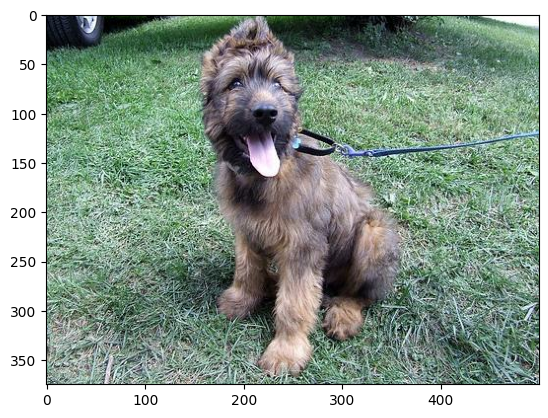

In [64]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

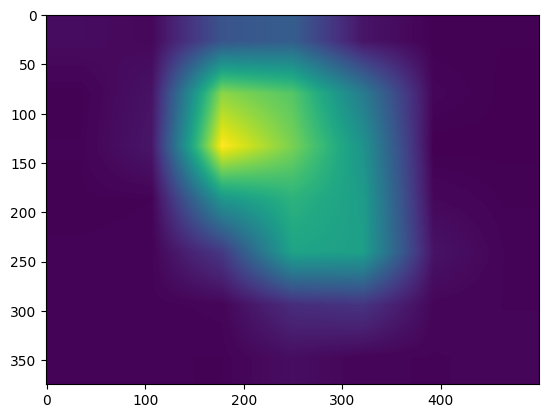

In [65]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [ ]:
# activation map에 음수값이 포함된 것을 확인, 수정 필요
min_value = np.min(cam_image)
max_value = np.max(cam_image)

print(min_value)
print(max_value)

-0.009727748
0.9976473


In [ ]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = np.clip(cam_image, a_min=0, a_max=None) # 음수 값을 0으로 처리
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    
    return cam_image

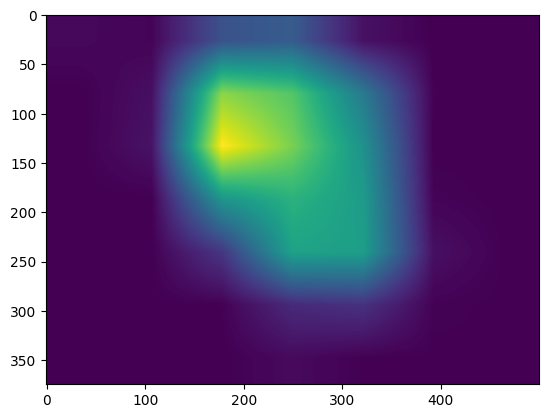

In [70]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [ ]:
# 해결
min_value = np.min(cam_image)
max_value = np.max(cam_image)

print(min_value)
print(max_value)

0.0
0.9976473


Activation 확인하기

In [85]:
def visualize_cam_on_image(src1, src2, alpha=0.8):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

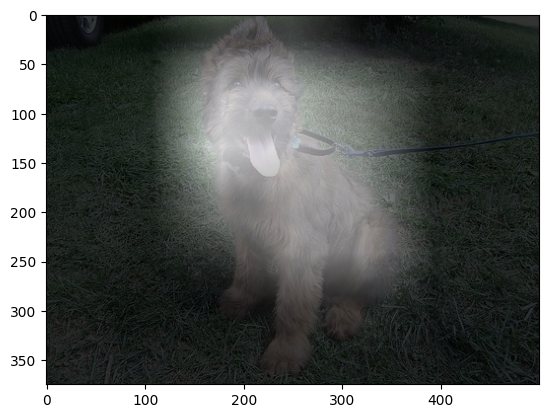

In [86]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

### Grad-CAM 구현하기

In [74]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = np.clip(grad_cam_image, a_min=0, a_max=None) # 음수 값을 0으로 처리
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

Activation 확인하기

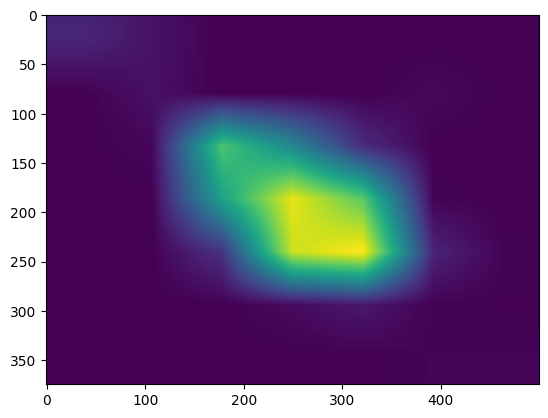

In [87]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

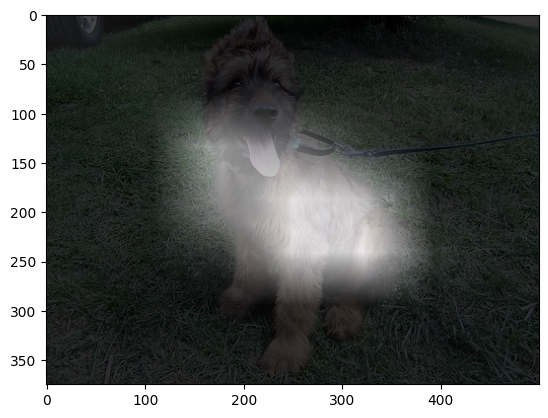

In [88]:
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image_grad = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image_grad)
plt.show()

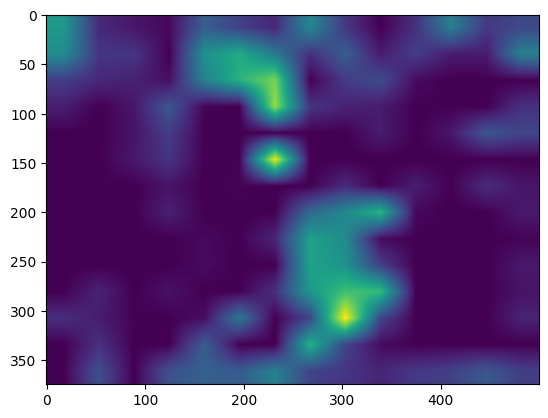

In [89]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

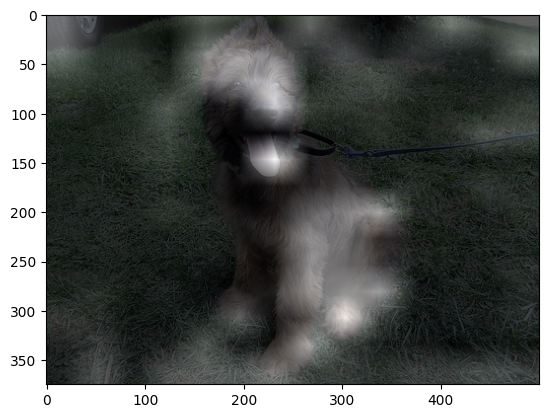

In [90]:
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image_grad = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image_grad)
plt.show()

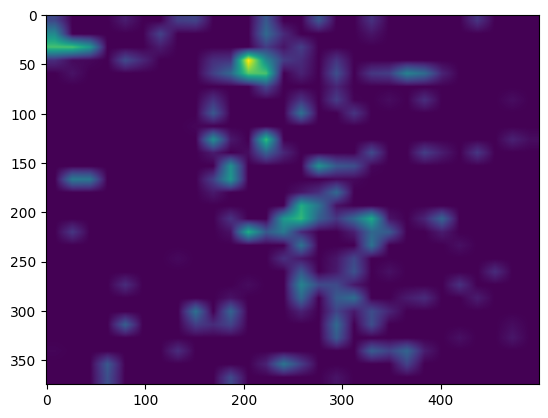

In [91]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

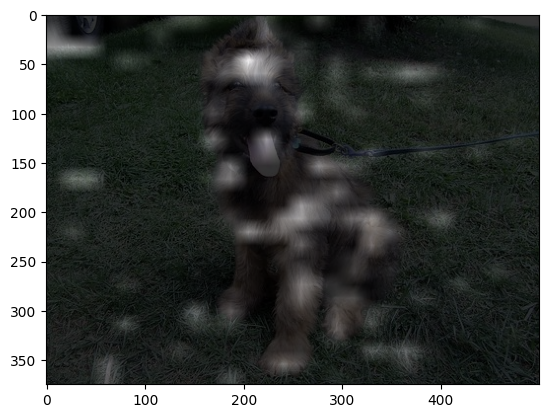

In [92]:
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image_grad = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image_grad)
plt.show()

현재 상황에서는 conv5 근처의 피처맵을 확인하는 것이 적절한 activation map을 보여주는 것을 확인, conv5 근처에서 최적의 피처맵을 다시 확인

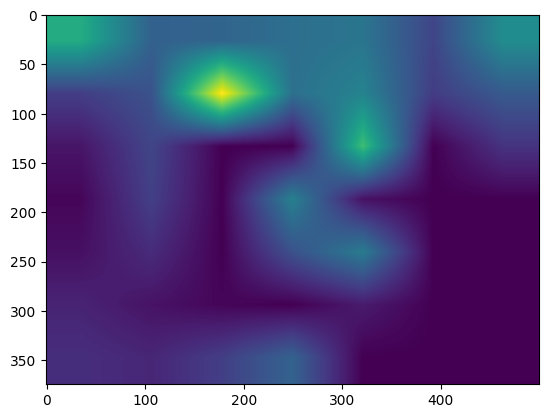

In [104]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block1_out', item)
plt.imshow(grad_cam_image)
plt.show()

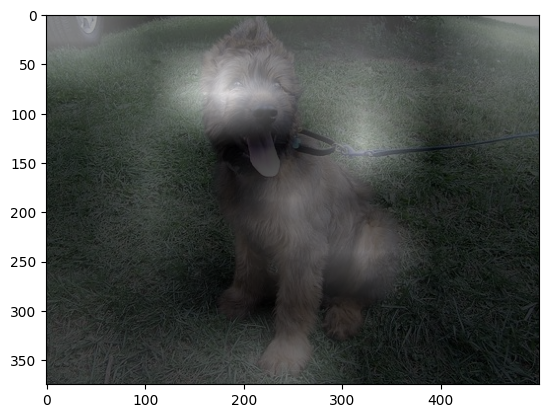

In [105]:
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image_grad = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image_grad)
plt.show()

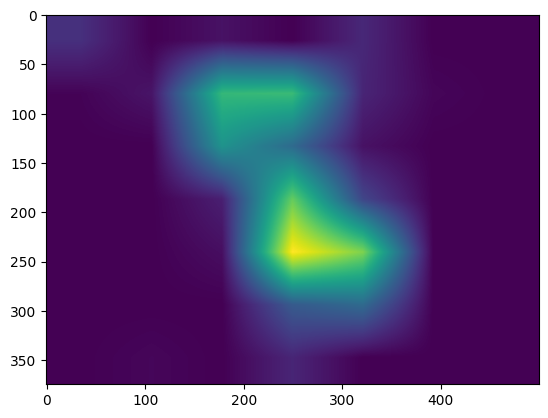

In [130]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block2_out', item)
plt.imshow(grad_cam_image)
plt.show()

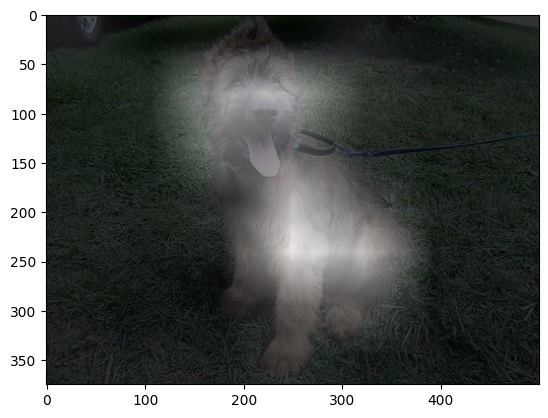

In [131]:
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image_grad = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image_grad)
plt.show()

conv5_block2_out을 기준으로 CAM과 비교하는 것이 적절하다고 판단

### BBOX와 IOU구하기

CAM에서의 BBOX와 IOU

In [125]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

bbox 그려보기

In [126]:
rect = get_bbox(cam_image)
rect

/tmp/ipykernel_17329/770630722.py:10: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  rect = np.int0(rect)


array([[100,   0],
       [380, -11],
       [394, 327],
       [115, 339]])

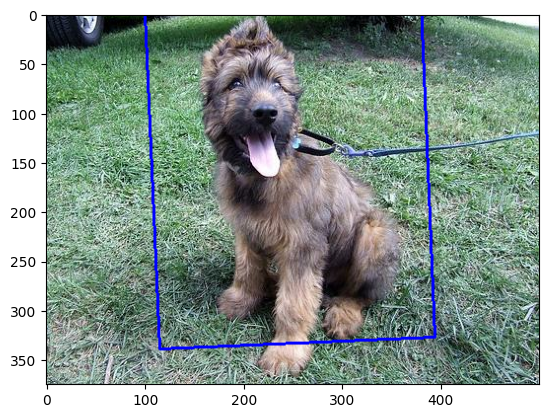

In [127]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

IOU 확인하기

In [97]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [98]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.029333333333333333, 0.2, 0.904, 0.788]

In [99]:
item['objects']['bbox']

array([[0.       , 0.304    , 0.9813333, 0.738    ]], dtype=float32)

In [100]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

CAM의 IOU값

In [101]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.6736970233654519

Grad-CAM에서의 BBOX와 IOU

In [132]:
rect = get_bbox(grad_cam_image)
rect

/tmp/ipykernel_17329/770630722.py:10: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  rect = np.int0(rect)


array([[ 91,  41],
       [356, -16],
       [434, 341],
       [169, 399]])

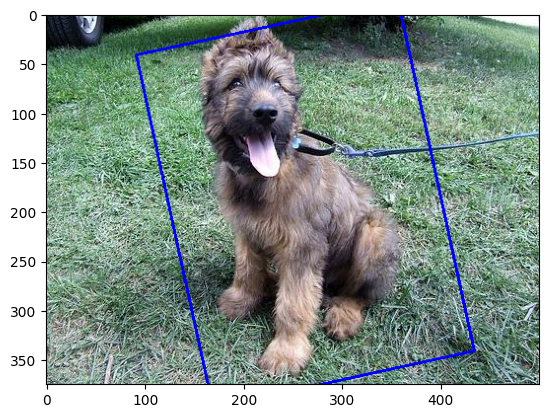

In [133]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [134]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.042666666666666665, 0.182, 1.064, 0.868]

Grad-CAM의 IOU값

In [135]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.5610031631088445

실제 bbox가 어떻게 되어 있는지 확인

In [138]:
def minmax_to_rect(bbox, image):
    # Reverse the normalization process
    y_min = int(bbox[0] * image.shape[0])
    x_min = int(bbox[1] * image.shape[1])
    y_max = int(bbox[2] * image.shape[0])
    x_max = int(bbox[3] * image.shape[1])

    # Create the rectangle (bounding box) as an array of coordinates
    rect = np.array([[x_min, y_min], [x_min, y_max], [x_max, y_max], [x_max, y_min]], dtype=np.int32)
    
    return rect

In [139]:
rect = minmax_to_rect(item['objects']['bbox'][0], item['image'])
rect

array([[151,   0],
       [151, 367],
       [368, 367],
       [368,   0]], dtype=int32)

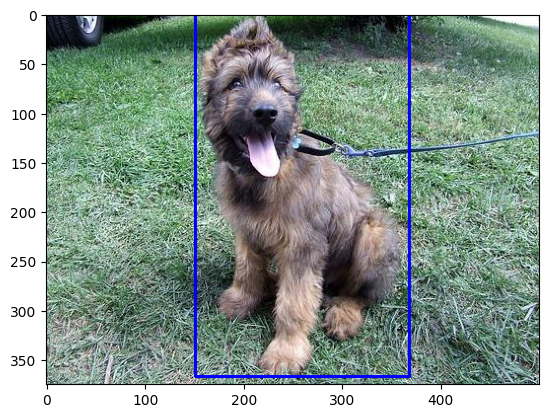

In [140]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

테스트 데이터셋 전체를 활용하여 평균 IOU로 최종 비교

In [ ]:
def calculate_iou_for_dataset(ds_test, cam_model):
    cam_iou_list = []
    grad_cam_iou_list = []
    
    # Iterate over the dataset
    for item in ds_test:
        # CAM
        cam_image = generate_cam(cam_model, item)
        rect = get_bbox(cam_image)
        pred_bbox = rect_to_minmax(rect, item['image'])
        cam_iou = get_iou(pred_bbox, item['objects']['bbox'][0])
        cam_iou_list.append(cam_iou)
        
        # Grad-CAM
        grad_cam_image = generate_grad_cam(cam_model, 'conv5_block2_out', item)
        rect = get_bbox(grad_cam_image)
        pred_bbox = rect_to_minmax(rect, item['image'])
        grad_cam_iou = get_iou(pred_bbox, item['objects']['bbox'][0])
        grad_cam_iou_list.append(grad_cam_iou)
    
    # IoU for CAM and Grad-CAM
    avg_cam_iou = np.mean(cam_iou_list)
    avg_grad_cam_iou = np.mean(grad_cam_iou_list)
    
    return avg_cam_iou, avg_grad_cam_iou, cam_iou_list, grad_cam_iou_list


avg_cam_iou, avg_grad_cam_iou, cam_iou_list, grad_cam_iou_list = calculate_iou_for_dataset(ds_test, cam_model)

print(f"Average IoU for CAM: {avg_cam_iou}")
print(f"Average IoU for Grad-CAM: {avg_grad_cam_iou}")


/tmp/ipykernel_17329/770630722.py:10: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  rect = np.int0(rect)


Average IoU for CAM: 0.5789372150295802
Average IoU for Grad-CAM: 0.37568230297993216


In [144]:
cam_iou_list = [float(i) for i in cam_iou_list]
grad_cam_iou_list = [float(i) for i in grad_cam_iou_list]
avg_cam_iou = float(avg_cam_iou)
avg_grad_cam_iou = float(avg_grad_cam_iou)

iou_results = {
    "avg_cam_iou": avg_cam_iou,
    "avg_grad_cam_iou": avg_grad_cam_iou,
    "cam_iou_list": cam_iou_list,
    "grad_cam_iou_list": grad_cam_iou_list
}

json_file_path = "./iou_results.json"

with open(json_file_path, "w") as json_file:
    json.dump(iou_results, json_file, indent=4)

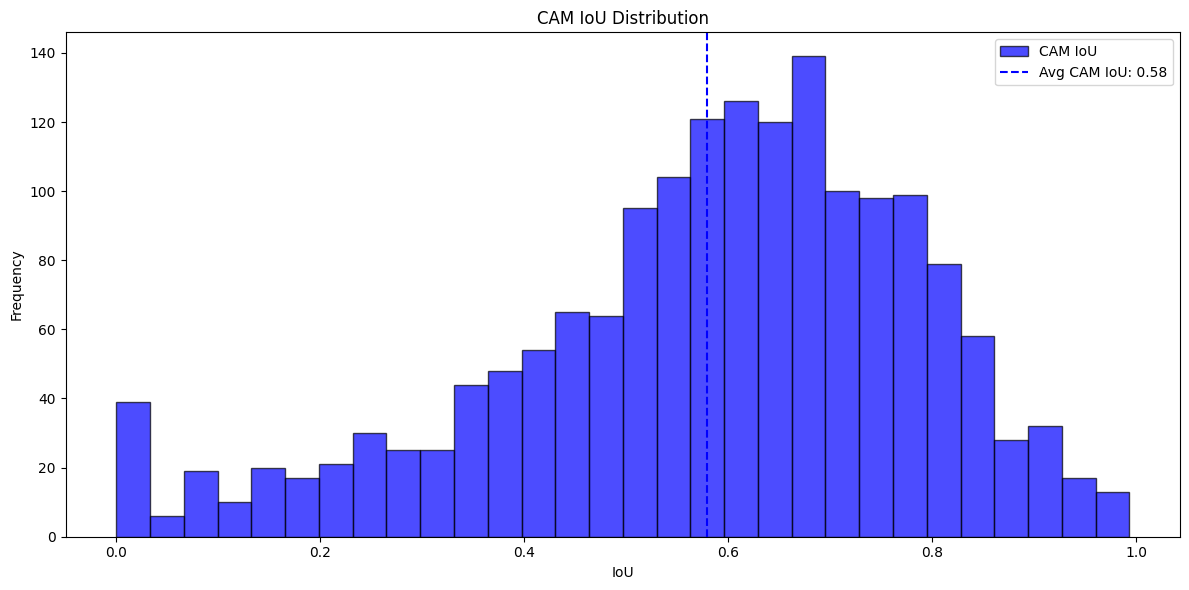

In [151]:
plt.figure(figsize=(12, 6))
plt.hist(cam_iou_list, bins=30, alpha=0.7, color='blue', label='CAM IoU', edgecolor='black')
plt.axvline(x=avg_cam_iou, color='blue', linestyle='--', label=f'Avg CAM IoU: {avg_cam_iou:.2f}')
plt.title('CAM IoU Distribution')
plt.xlabel('IoU')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

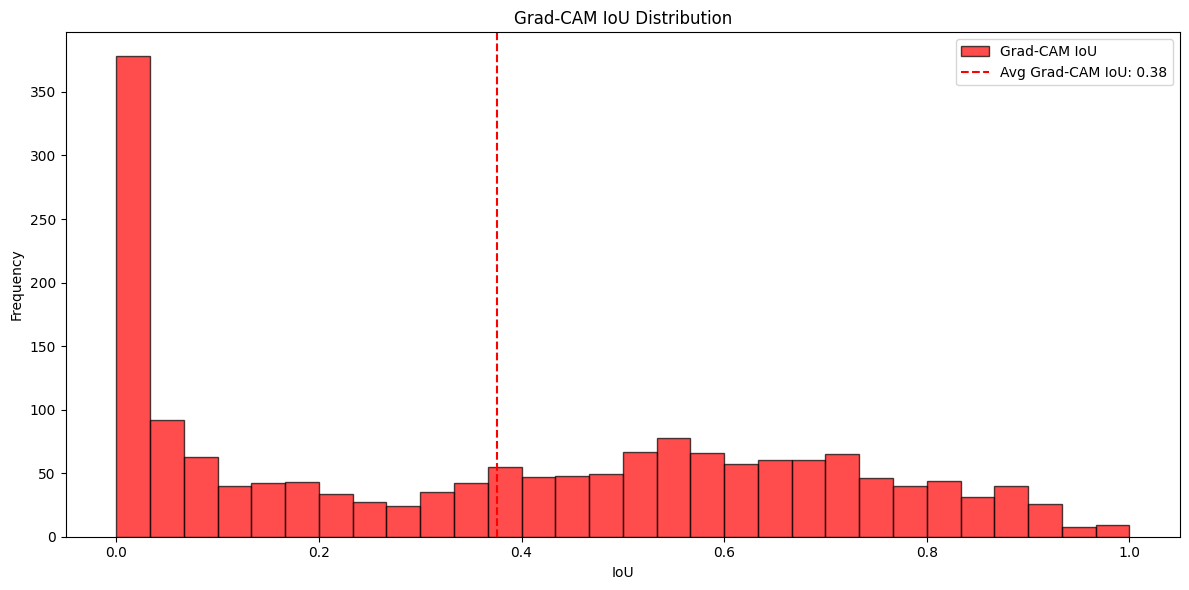

In [152]:
plt.figure(figsize=(12, 6))
plt.hist(grad_cam_iou_list, bins=30, alpha=0.7, color='red', label='Grad-CAM IoU', edgecolor='black')
plt.axvline(x=avg_grad_cam_iou, color='red', linestyle='--', label=f'Avg Grad-CAM IoU: {avg_grad_cam_iou:.2f}')
plt.title('Grad-CAM IoU Distribution')
plt.xlabel('IoU')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

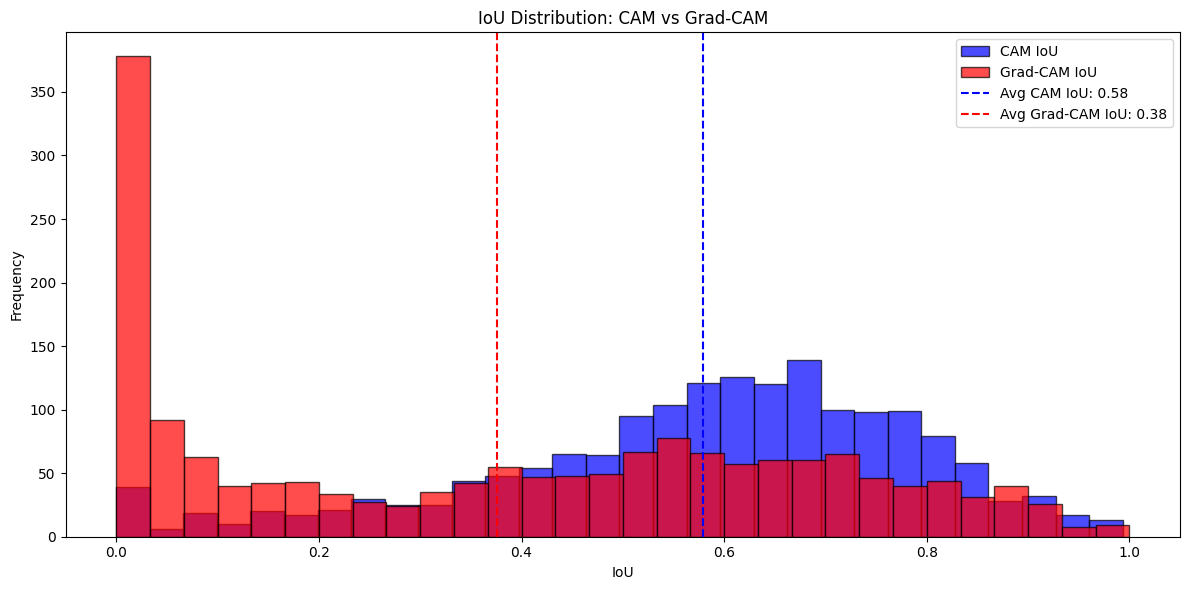

In [153]:
plt.figure(figsize=(12, 6))

plt.hist(cam_iou_list, bins=30, alpha=0.7, color='blue', label='CAM IoU', edgecolor='black')
plt.hist(grad_cam_iou_list, bins=30, alpha=0.7, color='red', label='Grad-CAM IoU', edgecolor='black')

plt.axvline(x=avg_cam_iou, color='blue', linestyle='--', label=f'Avg CAM IoU: {avg_cam_iou:.2f}')
plt.axvline(x=avg_grad_cam_iou, color='red', linestyle='--', label=f'Avg Grad-CAM IoU: {avg_grad_cam_iou:.2f}')


plt.title('IoU Distribution: CAM vs Grad-CAM')
plt.xlabel('IoU')
plt.ylabel('Frequency')

plt.legend()
plt.tight_layout()
plt.show()

##### 최종정리 : CAM vs Grad-CAM

| 방법                | IOU |
|---------------------|--------------|
| CAM        | 57.9%       |
| Grad-CAM     | 37.6%       |

* 이렇게 성능차이가 많이 나는 이유는 Grad-CAM의 피처맵을 선정할 때, 하나의 샘플 사진만을 기준으로 conv5_block2_out가 적절할 것이라고 가정했기 때문
* 실제 사진 내의 객체의 크기에 따라 피처맵을 가변적으로 선정할 수 있다면 지금처럼 IOU가 0이 나오지 않을 것이라고 생각
* 추가 실험을 통해, 현재 Grad-CAM에서 IOU가 0으로 판단되는 이미지를 crop하여 성능이 나아지는 파악하여 문제의 원인을 규명할 수 있음

##### 추가실험 : Grad-CAM

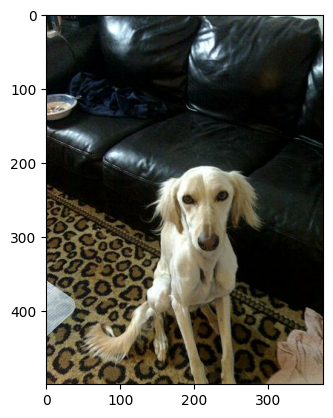

In [ ]:
#CAM에서 IOU가 35%이고 Grad-CAM에서 IOU가 0%인 이미지 활용
problem_item = list(ds_test.take(-1))[-2]
image = copy.deepcopy(problem_item['image'])
plt.imshow(image)
plt.show()

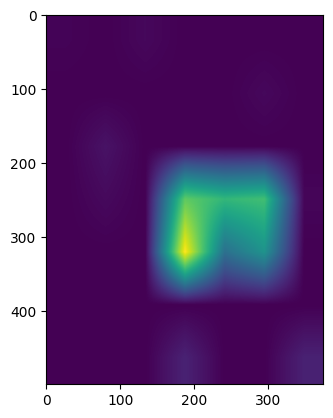

In [166]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block2_out', problem_item)
plt.imshow(grad_cam_image)
plt.show()

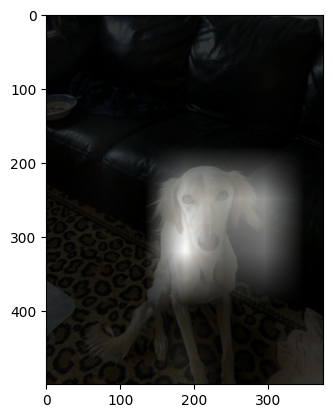

In [171]:
origin_image = problem_item['image'].numpy().astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image_grad = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image_grad)
plt.show()

In [163]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block2_out', problem_item)
rect = get_bbox(grad_cam_image)
rect

/tmp/ipykernel_17329/770630722.py:10: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  rect = np.int0(rect)


array([[324, 432],
       [374, 432],
       [374, 499],
       [324, 499]])

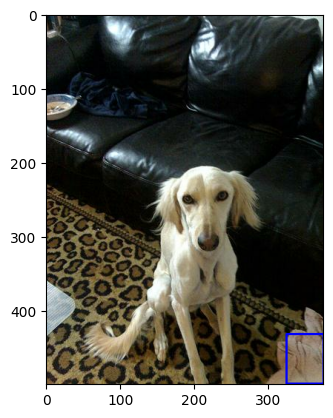

In [173]:
image = copy.deepcopy(origin_image)
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

지금 확인한 상황에서의 문제는 어떤 수준의 피처맵이냐기 보다는 bbox 추출방법에 문제가 있는 것으로 생각되어 threshold값을 바꿔보려함

In [184]:
def get_bbox(cam_image, score_thresh=0.1):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [185]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block2_out', problem_item)
rect = get_bbox(grad_cam_image)
rect

/tmp/ipykernel_17329/936368107.py:10: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  rect = np.int0(rect)


array([[138, 384],
       [140, 187],
       [340, 189],
       [338, 386]])

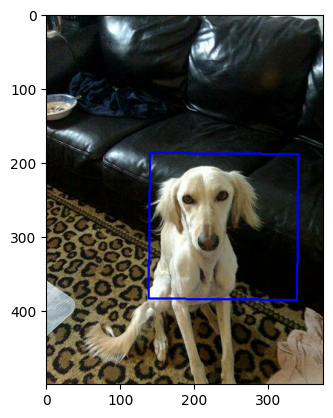

In [186]:
image = copy.deepcopy(origin_image)
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

score_thresh를 0.05에서 0.1로 바꿔 중요하다고 판단하는 기준을 엄격히하니 오히려 경계가 더 잘 추출되는 모습을 확인할 수 있었음. 이를 통해 너무 많은 값들이 포함되는 경우 경계를 오히려 찾기 힘든 상황이 생길 수 있다는 사실을 발견. (cv2.findContours함수에 적절한 값만 들어가야 적절한 경계를 찾아주는데 너무 많은 노이즈가 포함되었던 것이 원인)
따라서 좀 더 명확한 비교를 위해선 score_thresh값을 0.1로 둘 다 변경 / Grad-CAM만 변경 하는 등의 방법이 있지만 어떻게 최적화할 것인가와 남은 시간이 없어 우선 여기서 실험 종료

### 회고
이번 실험에서는 CAM과 Grad-CAM의 성능을 비교하는 것을 목표로 실험을 진행했으나 뒤늦게 문제가 파악되는 등 시간이 부족하여 적절한 비교까지 나아가지 못하여 아쉬움이 남습니다. 실험을 진행하면서 생겼던 문제를 정리하고 추후에 이를 보완할 계획입니다.

1. 활성화 값을 너무 넓게 포함할 경우 경계가 부정확하게 추출되는 문제 : CAM보다 Grad-CAM에서 이 문제가 더 심한 것으로 예상이 됩니다. 이러한 현상이 나타나는 이유를 정리하고 적절한 방법을 생각하여 추후에 실험할 계획입니다.

2. 원래의 예상은 이미지 안에 객체의 scale이 작을 경우 CAM에서 성능이 나오지 않지만 Grad-CAM에서 적절한 피처맵을 찾아 더 나은 성능을 보이거나, 이미지를 crop하여 객체의 scale을 높여 비교를 시도하려고 하였습니다. 추후에 이런 상황에 적합한 이미지를 찾게 된다면 시도해볼 계획입니다.